In [1]:
%matplotlib inline
import os.path
from fastai import *

In [2]:
from PIL import Image
import pandas as pd 
import numpy as np 

In [3]:
from fastai.text import *
PATH=Path('data')


In [4]:
test = pd.read_csv("data/test.csv")
train = pd.read_csv("data/train.csv")

In [5]:
train = train.head(5000)

In [6]:
test = test.head(5000)

In [7]:
import fastText as ft

In [8]:
ru_vecs = ft.load_model('data/wiki.ru.bin')

In [9]:
def get_vecs(lang, ft_vecs):
    vecd = {w:ft_vecs.get_word_vector(w) for w in ft_vecs.get_words()}
    pickle.dump(vecd, open(PATH/f'wiki.{lang}.pkl', 'wb'))
    return vecd

In [10]:
ru_vecd = get_vecs('ru', ru_vecs)

In [11]:
ft_words = ru_vecs.get_words(include_freq=True)
ft_word_dict = {k:v for k,v in zip(*ft_words)}
ft_words = sorted(ft_word_dict.keys(), key=lambda x: ft_word_dict[x])
len(ft_words)

1888423

In [12]:
dim_ru_vec = len(ru_vecd[','])
dim_ru_vec

300

In [13]:
ru_vecs = np.stack(list(ru_vecd.values()))
ru_vecs.mean(), ru_vecs.std()

(0.003615052, 0.29542154)

In [14]:
len(test), len(train)

(5000, 5000)

Turning CSV into lines

In [15]:
import re
re.sub("[()]", " ", "foo(a)")

'foo a '

In [16]:
#df = pd.DataFrame(columns=['text', "probability"])
#dict = {} 
text = []
probability = []
for i, r in train.iterrows():
    t = f'{r.region} {r.city} {r.parent_category_name} {r.category_name} {r.param_1} {r.param_2} {r.param_3} {r.title} {r.description} {r.price} {r.item_seq_number} {r.user_type} {"yes" if r.image else "no"}'
    p = r.deal_probability
    text.append(re.sub("[()]", " ", t))
    probability.append(p)
    #df.loc[len(df)] = [text, probability]
    if i % 100000 == 0: print(i)
    
#train_processed = df

0


In [17]:
pickle.dump(text, open('data/text.pkl', 'wb'))
pickle.dump(probability, open('data/probability.pkl', 'wb'))

In [18]:
text = pickle.load(open('data/text.pkl', 'rb'))
probability = pickle.load(open('data/probability.pkl', 'rb'))

In [19]:
text_tok = Tokenizer.proc_all_mp(partition_by_cores(text))

In [20]:
text_tok[0]

['свердловская',
 'область',
 'екатеринбург',
 'личные',
 'вещи',
 'товары',
 'для',
 'детей',
 'и',
 'игрушки',
 'постельные',
 'принадлежности',
 'nan',
 'nan',
 'кокоби',
 'кокон',
 'для',
 'сна',
 'кокон',
 'для',
 'сна',
 'малыша,пользовались',
 'меньше',
 'месяца.цвет',
 'серый',
 '400.0',
 '2',
 'private',
 'yes']

In [21]:
np.percentile([len(o) for o in text_tok], 90), np.percentile([len(o) for o in text_tok], 90)

(101.0, 101.0)

In [22]:
keep = np.array([len(o) < 101 for o in text_tok])

In [23]:
text_tok = np.array(text_tok)[keep]
probability = np.array(probability)[keep]

In [24]:
pickle.dump(text_tok, open('data/text_tok.pkl', 'wb'))
pickle.dump(probability, open('data/probability_k.pkl', 'wb'))


In [25]:
text_tok=pickle.load(open('data/text_tok.pkl', 'rb'))
probability=pickle.load(open('data/probability_k.pkl', 'rb'))

In [26]:
len(probability), len(text_tok)

(4499, 4499)

In [27]:
def toks2ids(tok, pre):
    freq = Counter(p for o in tok for p in o)
    itos = [o for o,c in freq.most_common(40000)]
    itos.insert(0, '_bos_')
    itos.insert(1, '_pad_')
    itos.insert(2, '_eos_')
    itos.insert(3, '_unk')
    itos.insert(4, 'nan')
    stoi = collections.defaultdict(lambda: 3, {v:k for k,v in enumerate(itos)})
    ids = np.array([([stoi[o] for o in p] + [2]) for p in tok])
    np.save(f'data/tmp_{pre}_ids.npy', ids)
    pickle.dump(itos, open(f'data/tmp_{pre}_itos.pkl', 'wb'))
    return ids, itos, stoi

In [28]:
text_ids, text_itos, text_stoi = toks2ids(text_tok, 'text')

In [29]:
def load_ids(pre):
    ids = np.load(f'data/tmp_{pre}_ids.npy')
    itos = pickle.load(open(f'data/tmp_{pre}_itos.pkl', 'rb'))
    stoi = collections.defaultdict(lambda: 3, {v:k for k, v in enumerate(itos)})
    return ids, itos, stoi

In [30]:
text_ids, text_itos, text_stoi = load_ids('text')

In [31]:
len(probability), len(text_ids)

(4499, 4499)

Training and validation data set

In [32]:
np.random.seed(42)
trn_keep = np.random.rand(len(text_ids)) > 0.1
trn = text_ids[trn_keep]
trn_y = probability[trn_keep]
val = text_ids[~trn_keep]
val_y = probability[~trn_keep]
len(trn), len(val)

(4017, 482)

In [51]:
class Seq2SeqDataset(Dataset):
    def __init__(self, x, y): self.x, self.y = x, y
    def __getitem__(self, idx): return A(self.x[idx], [int(self.y[idx]*1000)])
    def __len__(self): return len(self.x)

In [52]:
int(0.2312)

0

In [53]:
#trn_y = trn.iloc[:,-1]
#val_y = val.iloc[:,-1]

In [54]:
#trn = trn.iloc[:, :-1]
#val = val.iloc[:, :-1]

In [55]:
trn_ds = Seq2SeqDataset(trn, trn_y)
val_ds = Seq2SeqDataset(val, val_y)

In [56]:
batch_size=125

In [57]:
trn_samp = SortishSampler(trn, key=lambda x: len(trn[x]), bs=batch_size)
val_samp = SortSampler(val, key=lambda x: len(val[x]))

In [58]:
trn_dl = DataLoader(trn_ds, batch_size, transpose = True, transpose_y=True, num_workers=1, pad_idx=1, pre_pad=False,
                   sampler=trn_samp)
val_dl = DataLoader(val_ds, int(batch_size*1.6), transpose=True, transpose_y=True, num_workers=1, pad_idx = 1,
                pre_pad = False, sampler=val_samp)
md = ModelData(PATH, trn_dl, val_dl)

In [59]:
def create_emb(vecs, itos, em_sz):
    emb = nn.Embedding(len(itos), em_sz, padding_idx = 1)
    wgts = emb.weight.data # jeremy: this is a tensor
    miss = []
    for i, w in enumerate(itos):
        try: wgts[i] = torch.from_numpy(vecs[w] * 3) # jeremy: our stddev is 0.3, so mul by 3 to get to 1.0
        except: miss.append(w)
    print(len(miss), miss[5:10])
    return emb

In [60]:
num_hidden_features, num_layers = 256, 2

In [61]:
class Seq2SeqRNN(nn.Module):
    def __init__(self, vecs_enc, itos_enc, em_sz_enc, vecs_dec, itos_dec, em_sz_dec, num_hidden_features, out_sequence_length, num_layers=2):
        super().__init__()
        self.num_layers, self.num_hidden_features, self.out_sequence_length = num_layers, num_hidden_features, out_sequence_length
        self.emb_enc = create_emb(vecs_enc, itos_enc, em_sz_enc)
        self.emb_enc_drop = nn.Dropout(0.15)
        self.gru_enc = nn.GRU(em_sz_enc, num_hidden_features, num_layers=num_layers, dropout=0.25)
        self.out_enc = nn.Linear(num_hidden_features, em_sz_dec, bias=False)
        
        self.emb_dec = create_emb(vecs_dec, itos_dec, em_sz_dec)
        self.gru_dec = nn.GRU(em_sz_dec, em_sz_dec, num_layers=num_layers, dropout=0.1)
        self.out_drop = nn.Dropout(0.35)
        self.out = nn.Linear(em_sz_dec, len(itos_dec))
        self.out.weight.data = self.emb_dec.weight.data
    
    def forward(self, inp):
        sequence_length, batch_size = inp.size()
        h = self.initHidden(batch_size)
        emb = self.emb_enc_drop(self.emb_enc(inp))
        enc_out, h = self.gru_enc(emb, h)
        h = self.out_enc(h)
        
        dec_inp = V(torch.zeros(batch_size).long())
        res = []
        
        for i in range(self.out_sequence_length):
            # dec_inp: the previous word we translated
            emb = self.emb_dec(dec_inp).unsqueeze(0) # treat this as a sequence of length=1
            outp, h = self.gru_dec(emb, h)
            outp = self.out(self.out_drop(outp[0]))
            res.append(outp)
            dec_inp = V(outp.data.max(1)[1])
            if (dec_inp==1).all(): break
        return torch.stack(res)
    
    def initHidden(self, batch_size): return V(torch.zeros(self.num_layers, batch_size, self.num_hidden_features))
      


In [62]:
def seq2seq_loss(input, target):
    sequence_length, batch_size = target.size()
    sequence_length_in, batch_size_in, nc = input.size()
    # add some padding, because our sequence length might be different 
    if sequence_length > sequence_length_in: input = F.pad(input, (0, 0, 0, 0, 0, sequence_length-sequence_length_in))
    input = input[:sequence_length]
    return F.cross_entropy(input.view(-1, nc), target.view(-1)) 

In [63]:
opt_fn = partial(optim.Adam, betas=(0.8, 0.99))

In [64]:
rnn = Seq2SeqRNN(ru_vecd, text_itos, dim_ru_vec, ru_vecd, probability, 1, num_hidden_features, 101)
learn = RNN_Learner(md, SingleModel(to_gpu(rnn)), opt_fn=opt_fn)
learn.crit = seq2seq_loss

10080 ['t_up', '2', '4', '1', 'tk_rep']
4499 [0.80323, 0.0, 0.80323, 0.0, 0.0]


epoch      trn_loss   val_loss                            
    0      8.409717   6.308172  



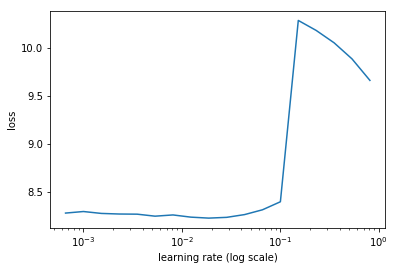

In [65]:
learn.lr_find()
learn.sched.plot()

In [68]:
learning_rate = 10e-2

In [69]:
learn.fit(learning_rate, 1, cycle_len=12, use_clr=(20, 10))

epoch      trn_loss   val_loss                            
    0      2.55616    3.159625  
    1      2.58848    3.199449                            
    2      2.582454   3.210205                            
    3      2.586457   3.211104                            
    4      2.582714   3.206109                            
    5      2.570099   3.214145                            
    6      2.545748   3.223959                            
    7      2.529531   3.220596                            
    8      2.521181   3.219215                            
    9      2.511277   3.222738                            
    10     2.515091   3.228326                            
    11     2.525018   3.230843                            



[array([ 3.23084])]

In [71]:
learn.save("initial.m")

In [72]:
learn.load("initial.m")

Test

In [73]:
x, y = next(iter(val_dl))
probs = learn.model(V(x))
preds = to_np(probs.max(2)[1])


In [80]:
str(10)

'10'